# AWS Automation 

In [1]:
# Lista las instancias administradas y sus costos
# ls_ins.ipynb

In [3]:
import boto3
#import botostubs
import pprint
import os

import altair as alt

import pandas as pd
import numpy as np

import ipywidgets as widgets
import datetime
from datetime import timedelta 

In [4]:
ec2 = boto3.resource('ec2') # type: botostubs.S3

instances = ec2.instances.filter(
    Filters=[{'Name': 'instance-state-name', 'Values': ['running']}])

print(instances)
print(' ')
print(dir(instances))
print(' ')
print(instances.all())
# exit(-1)

pprint.pprint(instances)

ec2.instancesCollection(ec2.ServiceResource(), ec2.Instance)
 
['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_clone', '_handler', '_model', '_params', '_parent', '_py_operation_name', 'all', 'create_tags', 'filter', 'limit', 'monitor', 'page_size', 'pages', 'reboot', 'start', 'stop', 'terminate', 'unmonitor']
 
ec2.instancesCollection(ec2.ServiceResource(), ec2.Instance)
ec2.instancesCollection(ec2.ServiceResource(), ec2.Instance)


In [7]:
print('Resumen de Instancias')
i = 0
for instance in instances:
    print(instance.id, instance.instance_type)
    #pprint.pprint(instance)
    if i > 3 :break
    i = i + 1

Resumen de Instancias
i-0d7dda8c364492754 t3a.2xlarge
i-08529a72d1ae3c78b t3a.2xlarge
i-0982e0fad1e761a54 t3a.micro
i-0fb8411f5f18c3807 t3a.large
i-03b65151326be6a7d t3a.large


In [6]:
print('Muesta de 3 Instancias')
i = 1
for instance in ec2.instances.all():
     print(
         "Id: {0}\nPlatform: {1}\nType: {2}\nPublic IPv4: {3}\nAMI: {4}\nState: {5}\n".format(
         instance.id, instance.platform, instance.instance_type, instance.public_ip_address, instance.image.id, instance.state
         )
     )
     if i > 2:
        break
     i = i + 1

Muesta de 3 Instancias
Id: i-0d7dda8c364492754
Platform: None
Type: t3a.2xlarge
Public IPv4: None
AMI: ami-02eac2c0129f6376b
State: {'Code': 16, 'Name': 'running'}

Id: i-08529a72d1ae3c78b
Platform: None
Type: t3a.2xlarge
Public IPv4: None
AMI: ami-02eac2c0129f6376b
State: {'Code': 16, 'Name': 'running'}

Id: i-0982e0fad1e761a54
Platform: None
Type: t3a.micro
Public IPv4: 52.44.250.185
AMI: ami-02eac2c0129f6376b
State: {'Code': 16, 'Name': 'running'}



---

# Costos

In [7]:
client = boto3.client('ce')

### Periodo a considerar 

In [8]:
hoy = datetime.datetime.today()
ayer = hoy + timedelta(days=-1)  

start_day_w = widgets.DatePicker(
    description='Desde:',
    disabled=False, 
    value= ayer     # datetime.date(2019, 7, 9),
)

end_day_w = widgets.DatePicker(
    description='Hasta:',
    disabled=False,
    value= hoy
)

widgets.HBox([start_day_w, end_day_w])

In [9]:
start_day  = start_day_w.value.strftime("%Y-%m-%d")
end_day    = end_day_w.value.strftime("%Y-%m-%d") #'2020-04-02'
account_no = '698412479679' 

In [10]:
print('Generando reporte: desde',start_day, '- hasta:',end_day)

Generando reporte: desde 2020-04-14 - hasta: 2020-04-15


In [11]:
result = client.get_cost_and_usage(
    TimePeriod = {
        'Start': start_day,
        'End': end_day
    },
    Granularity = 'DAILY',
    Filter = {
        "And": [{
            "Dimensions": {
                "Key": "LINKED_ACCOUNT",
                "Values": [account_no]
            }
        }, {
            "Not": {
                "Dimensions": {
                    "Key": "RECORD_TYPE",
                    "Values": ["Credit", "Refund"]
                }
            }
        }, {
            "Tags": {
                "Key": "environment",
                "Values": ['prod']
            }
        }]
    },
    Metrics = ["BlendedCost"],
    GroupBy = [
        {
            'Type': 'DIMENSION',
            'Key': 'SERVICE'
        },
        {
            'Type': 'DIMENSION',
            'Key': 'USAGE_TYPE'
        }
    ]
)

In [12]:
#result

In [13]:
result.keys()

dict_keys(['GroupDefinitions', 'ResultsByTime', 'ResponseMetadata'])

In [14]:
# Convierte a DataFrame

In [15]:
df = pd.DataFrame.from_dict(result['ResultsByTime'][0]['Groups'])

def get_amount(c):
    return c['BlendedCost']['Amount']
df['Amount'] = df['Metrics'].apply(get_amount)

def get_restype(c):
    return c[0]
df['TipoRecurso'] = df['Keys'].apply(get_restype)

df.sort_values(by='Amount', ascending=False, inplace=True);

In [22]:
df.head(3)

,Keys,Metrics,Amount,TipoRecurso
19,"[Amazon Elastic Compute Cloud - Compute, BoxUs...","{'BlendedCost': {'Amount': '7.2192', 'Unit': '...",7.2192,Amazon Elastic Compute Cloud - Compute
18,"[Amazon Elastic Compute Cloud - Compute, BoxUs...","{'BlendedCost': {'Amount': '28.8768', 'Unit': ...",28.8768,Amazon Elastic Compute Cloud - Compute
4,"[EC2 - Other, NatGateway-Hours]","{'BlendedCost': {'Amount': '2.16', 'Unit': 'US...",2.16,EC2 - Other


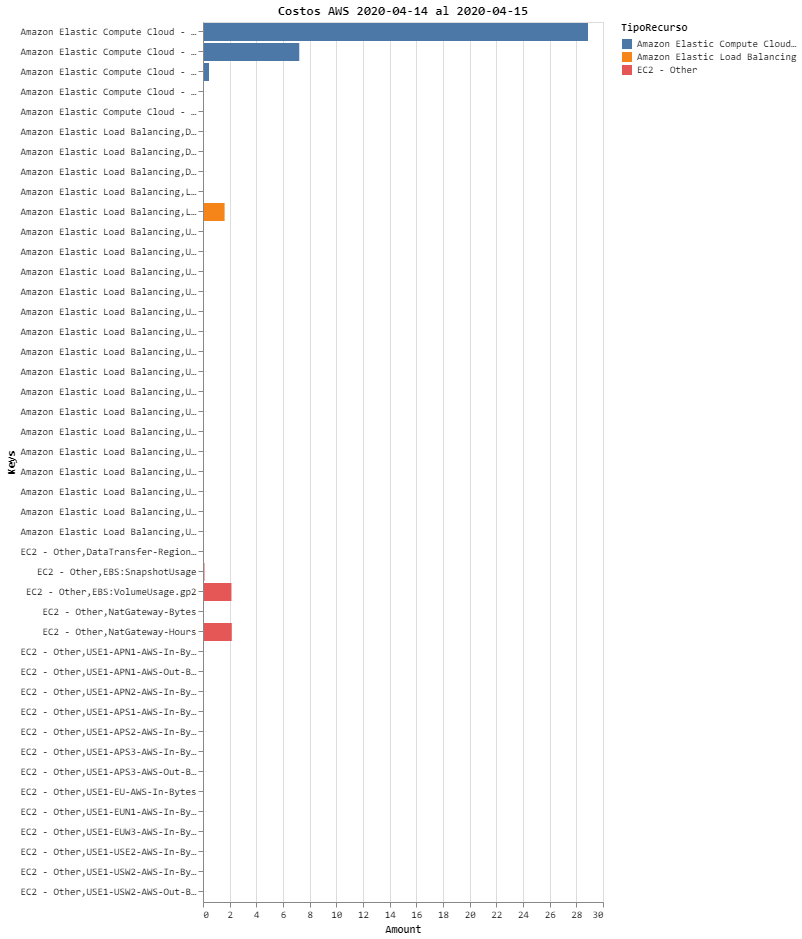

In [27]:
alt.Chart(df).mark_bar().encode(
    y='Keys:O',
    x='Amount:Q',
#    x=alt.X('Amount', scale=alt.Scale(type='log', base=10), axis=alt.Axis(orient='right')),
    color='TipoRecurso'
).properties(
    title='Costos AWS ' + start_day + ' al ' + end_day
)

In [23]:
import plotly.express as px
fig = px.scatter(df, x="Keys", y="Amount")
fig.show()